# Reddit AITA Finetuned Model Evaluation

In [ ]:
!pip install datasets transformers evaluate rouge_score peft accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/4

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# Load dataset to evaluate on
from datasets import load_dataset
dataset = load_dataset("MattBoraske/reddit-AITA-binary-submissions-and-comments-top-2k")

ModuleNotFoundError: No module named 'datasets'

In [ ]:
import torch
import numpy as np
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re

## Flan-T5 evaluation

In [ ]:
FLAN_T5_ENCODER_CONTEXT_WINDOW_SIZE = 1024
FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE = 256

### Classifications

In [ ]:
BASE_MODEL = "google/flan-t5-xxl"
FINETUNED_MODEL = "MattBoraske/flan-t5-xxl-reddit-AITA-binary-top-2k"

In [ ]:
# Load model and tokenizer
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
config = PeftConfig.from_pretrained(FINETUNED_MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(
    BASE_MODEL,
    device_map = "auto",
    torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(model, FINETUNED_MODEL)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/9.60G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/6.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [ ]:
def get_model_predictions(model, sample):

    # tokenize input
    input_ids = tokenizer(sample['flanT5_instruction'], max_length=FLAN_T5_ENCODER_CONTEXT_WINDOW_SIZE, padding='max_length', return_tensors="pt", truncation=True).input_ids.cuda()

    # generate and decode prediction
    outputs = model.generate(
      input_ids=input_ids,
      max_new_tokens=FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE,
      repetition_penalty=1.5
    )
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)

    # get AITA classification
    AITA_class = find_earliest_classification(prediction)

    # get reference text and AITA decision
    reference = sample['top_comment_1']
    correct_AITA_class = sample['top_comment_1_classification']

    # get ambiguity_score
    ambiguity_score = sample['ambiguity_score']

    # return tuple of input text, prediction, reference text, predicted AITA class, correct AITA class, and ambiguity score
    print(f'Predicted AITA_classs: {AITA_class}\tCorrect AITA_classs: {correct_AITA_class}')
    return sample['submission_text'], prediction, reference, AITA_class, correct_AITA_class, ambiguity_score

def find_earliest_classification(text):
    '''
    Find the earliest AITA classification in a text.

    Args:
        text (str): The text to search for AITA classifications in.

    Returns:
        str: The earliest classification found in the text.
    '''

    # classifications mapped to their keywords
    classes_dictionary = {
      'NTA': ['not the asshole', 'not the a\*\*hole', 'nta', 'you would not be the asshole', 'you would not be the a**hole', 'ywnbta', 'n t a', 'y w b t a'],
      'NAH': ['no assholes here', 'no a\*\*holes here', 'nah', 'n a h'],
      'ESH': ['everyone sucks here', 'esh', 'e s h'],
      'INFO': ['more information needed', 'more info needed', 'more information required', 'more info required', 'info'],
      'YTA': ['you\'re the asshole', 'you\'re the a\*\*hole', 'youre the asshole', 'youre the a\*\*hole', 'yta', 'you would be the asshole', 'you would be the a\*\*hole', 'ywbta', 'y t a', 'y w b t a']
    }

    # track earliest match
    earliest_match = None
    earliest_match_pos = float('inf')  # Initially set to infinity

    # convert input text to lowercase
    text = text.lower()

    # go through all classifications and their keywords
    for key, phrases in classes_dictionary.items():
        # Create a regex pattern that includes the classification keywords
        pattern = r'\b(' + '|'.join(map(re.escape, phrases)) + r')\b'

        # Search for any keywords in the input text
        for match in re.finditer(pattern, text, re.IGNORECASE):
            if match.start() < earliest_match_pos:
                # Update the earliest match if this match is earlier
                earliest_match = key
                earliest_match_pos = match.start()

    # return the class that had the earliest match
    return earliest_match if earliest_match is not None else 'NO CLASS'

In [ ]:
from collections import defaultdict
from tqdm import tqdm

# load first N samples in test dataset
test_dataset = dataset['test']

# run predictions
test_results = defaultdict(list)

for sample in tqdm(test_dataset):
    i,p,l,c,cc,a = get_model_predictions(model, sample)
    test_results['submission_texts'].append(i)
    test_results['prediction_texts'].append(p)
    test_results['top_comment_texts'].append(l)
    test_results['predicted_AITA_classes'].append(c)
    test_results['correct_AITA_classes'].append(cc)
    test_results['ambiguity_scores'].append(a)

In [ ]:
import json

# Saving as JSON
with open("flanT5_xl_binary_2k_evaluation.json", "w") as file:
    json.dump(dict(test_results), file)

In [ ]:
from collections import Counter

predicted_class_counts = Counter(test_results['predicted_AITA_classes'])
correct_class_counts = Counter(test_results['correct_AITA_classes'])

# print the results
print(predicted_class_counts)
print(correct_class_counts)

Counter({'YTA': 364, 'NTA': 36})
Counter({'YTA': 200, 'NTA': 200})


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def evaluate_model_classifications(test_results, output_directory, plot_title, confusion_matrix_file, classification_report_file):
  '''
  Evaluate the model's classifications using a confusion matrix and classification report.

  Parameters:
  test_results (dict): A dictionary containing the following keys:
    'predicted_AITA_classes': A list of predicted AITA classes.
    'correct_AITA_classes': A list of correct AITA classes.
  output_directory (str): The directory to save the output files.
  plot_title (str): The title of the confusion matrix plot.
  confusion_matrix_file (str): The file path to save the confusion matrix.
  classification_report_file (str): The file path to save the classification report.

  Returns: None - saves the confusion matrix and classification report.
  '''

  y_pred, y_true = [], []
  for l1, l2 in zip(test_results['predicted_AITA_classes'], test_results['correct_AITA_classes']):
      if l1 != "NO CLASS":
          y_pred.append(l1)
          y_true.append(l2)

  # Create the confusion matrix
  class_names = ['NTA','NAH','INFO','ESH','YTA']
  cm = confusion_matrix(y_true, y_pred, labels=class_names)

  with open(output_directory + '/' + confusion_matrix_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(cm)

  # Plotting
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title(f'{plot_title}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.savefig(f"{plot_title}.png")
  plt.show()

  classification_metrics = classification_report(y_true,y_pred,labels=class_names)
  print(f'\nClassification report:\n\n {classification_metrics}')

  # save classifications metric to output text file:
  with open(f"{classification_report_file}", "w") as f:
      f.write(classification_metrics)

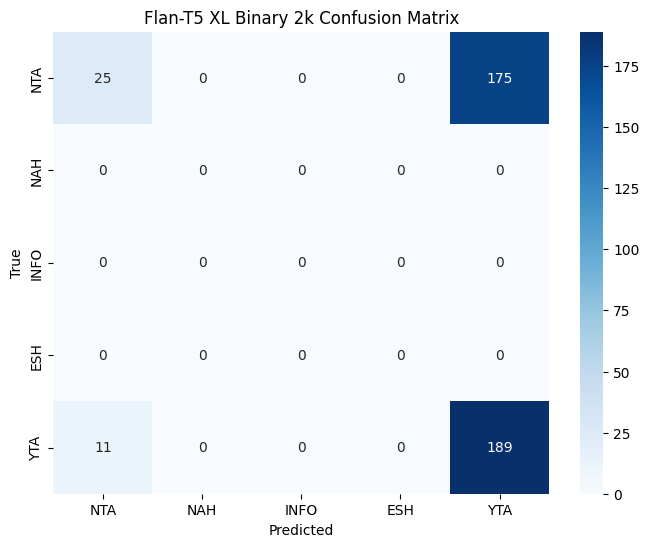


Classification report:

               precision    recall  f1-score   support

         NTA       0.69      0.12      0.21       200
         NAH       0.00      0.00      0.00         0
        INFO       0.00      0.00      0.00         0
         ESH       0.00      0.00      0.00         0
         YTA       0.52      0.94      0.67       200

   micro avg       0.54      0.54      0.54       400
   macro avg       0.24      0.21      0.18       400
weighted avg       0.61      0.54      0.44       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
evaluate_model_classifications(
  test_results=test_results,
  plot_title='Flan-T5 XL Binary 2k Confusion Matrix',
  output_directory='flanT5_xl_binary_2k_evaluation',
  confusion_matrix_file='flanT5_xl_binary_2k_confusion_matrix.csv',
  classification_report_file='flanT5_xl_binary_2k_classification_report.txt'
)

## Flan-T5 evaluation

In [ ]:
MAX_NEW_TOKENS = 256
FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE = 256

FINETUNED_MODEL = "MattBoraske/llama-2-7b-chat-reddit-AITA-top-2k"

### Classifications

In [ ]:
# Load model and tokenizer
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
import torch

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("MattBoraske/llama-2-7b-chat-reddit-AITA")
model = AutoModelForCausalLM.from_pretrained(
    FINETUNED_MODEL,
    device_map = "auto",
    torch_dtype=torch.bfloat16
)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/9.60G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/6.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [ ]:
def get_model_predictions(model, sample):

    # tokenize input
    input_ids = tokenizer(sample['flanT5_instruction'], max_length=FLAN_T5_ENCODER_CONTEXT_WINDOW_SIZE, padding='max_length', return_tensors="pt", truncation=True).input_ids.cuda()

    # generate and decode prediction
    outputs = model.generate(
      input_ids=input_ids,
      max_new_tokens=FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE,
      repetition_penalty=1.5
    )
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)

    # get AITA classification
    AITA_class = find_earliest_classification(prediction)

    # get reference text and AITA decision
    reference = sample['top_comment_1']
    correct_AITA_class = sample['top_comment_1_classification']

    # get ambiguity_score
    ambiguity_score = sample['ambiguity_score']

    # return tuple of input text, prediction, reference text, predicted AITA class, correct AITA class, and ambiguity score
    print(f'Predicted AITA_classs: {AITA_class}\tCorrect AITA_classs: {correct_AITA_class}')
    return sample['submission_text'], prediction, reference, AITA_class, correct_AITA_class, ambiguity_score

def find_earliest_classification(text):
    '''
    Find the earliest AITA classification in a text.

    Args:
        text (str): The text to search for AITA classifications in.

    Returns:
        str: The earliest classification found in the text.
    '''

    # classifications mapped to their keywords
    classes_dictionary = {
      'NTA': ['not the asshole', 'not the a\*\*hole', 'nta', 'you would not be the asshole', 'you would not be the a**hole', 'ywnbta', 'n t a', 'y w b t a'],
      'NAH': ['no assholes here', 'no a\*\*holes here', 'nah', 'n a h'],
      'ESH': ['everyone sucks here', 'esh', 'e s h'],
      'INFO': ['more information needed', 'more info needed', 'more information required', 'more info required', 'info'],
      'YTA': ['you\'re the asshole', 'you\'re the a\*\*hole', 'youre the asshole', 'youre the a\*\*hole', 'yta', 'you would be the asshole', 'you would be the a\*\*hole', 'ywbta', 'y t a', 'y w b t a']
    }

    # track earliest match
    earliest_match = None
    earliest_match_pos = float('inf')  # Initially set to infinity

    # convert input text to lowercase
    text = text.lower()

    # go through all classifications and their keywords
    for key, phrases in classes_dictionary.items():
        # Create a regex pattern that includes the classification keywords
        pattern = r'\b(' + '|'.join(map(re.escape, phrases)) + r')\b'

        # Search for any keywords in the input text
        for match in re.finditer(pattern, text, re.IGNORECASE):
            if match.start() < earliest_match_pos:
                # Update the earliest match if this match is earlier
                earliest_match = key
                earliest_match_pos = match.start()

    # return the class that had the earliest match
    return earliest_match if earliest_match is not None else 'NO CLASS'

In [ ]:
from collections import defaultdict
from tqdm import tqdm

# load first N samples in test dataset
test_dataset = dataset['test']

# run predictions
test_results = defaultdict(list)

for sample in tqdm(test_dataset):
    i,p,l,c,cc,a = get_model_predictions(model, sample)
    test_results['submission_texts'].append(i)
    test_results['prediction_texts'].append(p)
    test_results['top_comment_texts'].append(l)
    test_results['predicted_AITA_classes'].append(c)
    test_results['correct_AITA_classes'].append(cc)
    test_results['ambiguity_scores'].append(a)

In [ ]:
import json

# Saving as JSON
with open("flanT5_xl_binary_2k_evaluation.json", "w") as file:
    json.dump(dict(test_results), file)

In [ ]:
from collections import Counter

predicted_class_counts = Counter(test_results['predicted_AITA_classes'])
correct_class_counts = Counter(test_results['correct_AITA_classes'])

# print the results
print(predicted_class_counts)
print(correct_class_counts)

Counter({'YTA': 364, 'NTA': 36})
Counter({'YTA': 200, 'NTA': 200})


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def evaluate_model_classifications(test_results, output_directory, plot_title, confusion_matrix_file, classification_report_file):
  '''
  Evaluate the model's classifications using a confusion matrix and classification report.

  Parameters:
  test_results (dict): A dictionary containing the following keys:
    'predicted_AITA_classes': A list of predicted AITA classes.
    'correct_AITA_classes': A list of correct AITA classes.
  output_directory (str): The directory to save the output files.
  plot_title (str): The title of the confusion matrix plot.
  confusion_matrix_file (str): The file path to save the confusion matrix.
  classification_report_file (str): The file path to save the classification report.

  Returns: None - saves the confusion matrix and classification report.
  '''

  y_pred, y_true = [], []
  for l1, l2 in zip(test_results['predicted_AITA_classes'], test_results['correct_AITA_classes']):
      if l1 != "NO CLASS":
          y_pred.append(l1)
          y_true.append(l2)

  # Create the confusion matrix
  class_names = ['NTA','NAH','INFO','ESH','YTA']
  cm = confusion_matrix(y_true, y_pred, labels=class_names)

  with open(output_directory + '/' + confusion_matrix_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(cm)

  # Plotting
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title(f'{plot_title}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.savefig(f"{plot_title}.png")
  plt.show()

  classification_metrics = classification_report(y_true,y_pred,labels=class_names)
  print(f'\nClassification report:\n\n {classification_metrics}')

  # save classifications metric to output text file:
  with open(f"{classification_report_file}", "w") as f:
      f.write(classification_metrics)

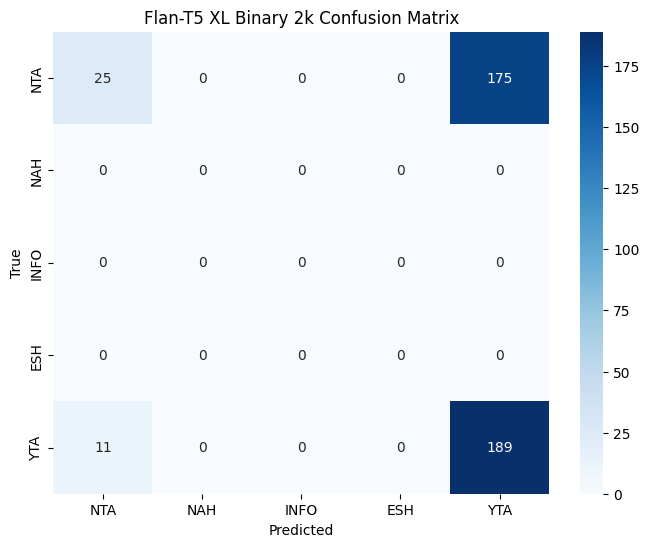


Classification report:

               precision    recall  f1-score   support

         NTA       0.69      0.12      0.21       200
         NAH       0.00      0.00      0.00         0
        INFO       0.00      0.00      0.00         0
         ESH       0.00      0.00      0.00         0
         YTA       0.52      0.94      0.67       200

   micro avg       0.54      0.54      0.54       400
   macro avg       0.24      0.21      0.18       400
weighted avg       0.61      0.54      0.44       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
evaluate_model_classifications(
  test_results=test_results,
  plot_title='Flan-T5 XL Binary 2k Confusion Matrix',
  output_directory='flanT5_xl_binary_2k_evaluation',
  confusion_matrix_file='flanT5_xl_binary_2k_confusion_matrix.csv',
  classification_report_file='flanT5_xl_binary_2k_classification_report.txt'
)